# Checkpoint 2: MDPs and the Bellman Equation

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Define** the components of a Markov Decision Process (MDP)
2. **Explain** the Bellman equation and its role in RL
3. **Implement** tabular Q-learning from scratch
4. **Train** an agent to solve FrozenLake
5. **Visualize** and interpret learned Q-values and policies

---

## 1. Environment Setup

In [1]:
# Install required packages
!pip install -q gymnasium numpy matplotlib seaborn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

print(f"Gymnasium version: {gym.__version__}")
print("All imports successful!")

Gymnasium version: 1.2.3
All imports successful!


---

## 2. Theory: Markov Decision Processes (MDPs)

An MDP is the mathematical framework that formalizes reinforcement learning problems.

### The Five Components of an MDP

An MDP is defined by the tuple **(S, A, P, R, gamma)**:

| Component | Symbol | Description | Mario Kart Example |
|-----------|--------|-------------|--------------------|
| **States** | S | All possible situations the agent can be in | Position on track, speed, items held, lap number |
| **Actions** | A | All possible actions the agent can take | Accelerate, brake, steer left/right, use item, drift |
| **Transition Probability** | P(s'\|s,a) | Probability of moving to state s' given state s and action a | If at position X going fast and steering left, likely end up at position Y |
| **Reward Function** | R(s,a,s') | Reward received for transitioning from s to s' via action a | +100 for crossing finish line, +10 for passing opponent, -50 for falling off |
| **Discount Factor** | gamma | How much to value future vs immediate rewards (0 to 1) | gamma=0.99 means we care a lot about future rewards (winning the race) |

### The Markov Property

The key assumption: **The future only depends on the current state, not the history.**

$$P(s_{t+1} | s_t, a_t, s_{t-1}, a_{t-1}, ..., s_0) = P(s_{t+1} | s_t, a_t)$$

In Mario Kart terms: To decide what happens next, we only need to know our current position, speed, and items - not how we got here.

---

## 3. Theory: The Bellman Equation

### Value Functions

We need a way to measure "how good" it is to be in a state or take an action:

- **State-Value Function V(s)**: Expected total reward starting from state s and following policy pi
- **Action-Value Function Q(s,a)**: Expected total reward starting from state s, taking action a, then following policy pi

### The Bellman Equation for Q-values

The Bellman equation expresses a recursive relationship:

$$Q(s, a) = R(s, a) + \gamma \sum_{s'} P(s'|s,a) \max_{a'} Q(s', a')$$

**In plain English:**
> The value of taking action a in state s equals the immediate reward PLUS the discounted value of the best action in the next state.

### Why This Matters

The Bellman equation gives us a way to **iteratively improve** our estimates of Q-values:

1. Start with random Q-value guesses
2. Take actions, observe rewards and next states
3. Update Q-values using the Bellman equation
4. Repeat until Q-values converge

This is the foundation of Q-learning!

---

## 4. Theory: Q-Learning Algorithm

Q-learning is a **model-free** algorithm that learns Q-values directly from experience.

### Pseudocode

```
Algorithm: Q-Learning
------------------------
Initialize Q(s, a) arbitrarily for all states s and actions a
Set hyperparameters: alpha (learning rate), gamma (discount), epsilon (exploration)

For each episode:
    Initialize state s
    
    While episode not done:
        # Epsilon-greedy action selection
        With probability epsilon:
            Select random action a
        Otherwise:
            Select a = argmax_a Q(s, a)
        
        # Take action and observe result
        Take action a, observe reward r and next state s'
        
        # Q-learning update (the Bellman equation in action!)
        Q(s, a) <- Q(s, a) + alpha * [r + gamma * max_a' Q(s', a') - Q(s, a)]
        
        # Move to next state
        s <- s'
```

### Key Components

- **Learning Rate (alpha)**: How much to update Q-values (0.1 to 0.5 typical)
- **Discount Factor (gamma)**: How much to value future rewards (0.9 to 0.99 typical)
- **Epsilon (exploration rate)**: Probability of taking random action (often starts at 1.0 and decays)

---

## 5. The FrozenLake Environment

FrozenLake is a grid world where an agent must navigate from Start (S) to Goal (G) while avoiding Holes (H).

```
SFFF    S = Start
FHFH    F = Frozen (safe)
FFFH    H = Hole (game over!)
HFFG    G = Goal (reward!)
```

**Actions:** 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP

**Reward:** +1 for reaching Goal, 0 otherwise

In [3]:
# Create the FrozenLake environment (deterministic version first)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)

print("=" * 50)
print("FROZENLAKE ENVIRONMENT (Deterministic)")
print("=" * 50)
print(f"\nObservation Space: {env.observation_space}")
print(f"  - Number of states: {env.observation_space.n}")
print(f"\nAction Space: {env.action_space}")
print(f"  - Number of actions: {env.action_space.n}")
print(f"  - Actions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP")

# Show the map
print("\nEnvironment Map:")
print("SFFF")
print("FHFH")
print("FFFH")
print("HFFG")
print("\nS=Start, F=Frozen, H=Hole, G=Goal")

FROZENLAKE ENVIRONMENT (Deterministic)

Observation Space: Discrete(16)
  - Number of states: 16

Action Space: Discrete(4)
  - Number of actions: 4
  - Actions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP

Environment Map:
SFFF
FHFH
FFFH
HFFG

S=Start, F=Frozen, H=Hole, G=Goal


---

## 6. Implementing Tabular Q-Learning from Scratch

In [4]:
class QLearningAgent:
    """
    Tabular Q-Learning Agent.
    
    Learns Q-values for discrete state-action pairs using the Bellman equation.
    """
    
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        """
        Initialize the Q-learning agent.
        
        Args:
            n_states: Number of states in the environment
            n_actions: Number of actions available
            learning_rate: Alpha - how fast to update Q-values
            discount_factor: Gamma - how much to value future rewards
            epsilon_start: Initial exploration rate
            epsilon_end: Minimum exploration rate
            epsilon_decay: Decay factor for epsilon after each episode
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Initialize Q-table with zeros
        # Shape: (n_states, n_actions)
        self.q_table = np.zeros((n_states, n_actions))
    
    def select_action(self, state):
        """
        Select action using epsilon-greedy policy.
        
        Args:
            state: Current state
            
        Returns:
            Selected action
        """
        if np.random.random() < self.epsilon:
            # Exploration: random action
            return np.random.randint(self.n_actions)
        else:
            # Exploitation: best known action
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Update Q-value using the Bellman equation.
        
        Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode ended
        """
        # Current Q-value
        current_q = self.q_table[state, action]
        
        # Target Q-value (using Bellman equation)
        if done:
            # No future rewards if episode ended
            target_q = reward
        else:
            # Reward + discounted max future Q-value
            target_q = reward + self.gamma * np.max(self.q_table[next_state])
        
        # Q-learning update
        self.q_table[state, action] = current_q + self.lr * (target_q - current_q)
    
    def decay_epsilon(self):
        """Decay exploration rate after each episode."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def get_policy(self):
        """Return the greedy policy (best action for each state)."""
        return np.argmax(self.q_table, axis=1)


print("Q-Learning Agent class defined!")

Q-Learning Agent class defined!


---

## 7. Training the Q-Learning Agent

In [5]:
def train_q_learning(env, agent, n_episodes=10000, print_interval=1000):
    """
    Train Q-learning agent on the environment.
    
    Args:
        env: Gymnasium environment
        agent: Q-learning agent
        n_episodes: Number of episodes to train
        print_interval: How often to print progress
        
    Returns:
        episode_rewards: List of total rewards per episode
        episode_lengths: List of steps per episode
    """
    episode_rewards = []
    episode_lengths = []
    success_count = 0
    
    print(f"Training Q-learning agent for {n_episodes} episodes...")
    print("=" * 60)
    
    for episode in range(n_episodes):
        state, info = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Take action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-values
            agent.update(state, action, reward, next_state, done)
            
            # Track metrics
            total_reward += reward
            steps += 1
            state = next_state
        
        # Decay exploration rate
        agent.decay_epsilon()
        
        # Record episode metrics
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        if total_reward > 0:
            success_count += 1
        
        # Print progress
        if (episode + 1) % print_interval == 0:
            recent_rewards = episode_rewards[-print_interval:]
            success_rate = sum(1 for r in recent_rewards if r > 0) / len(recent_rewards)
            print(f"Episode {episode + 1:5d} | "
                  f"Success Rate: {success_rate:.2%} | "
                  f"Epsilon: {agent.epsilon:.4f} | "
                  f"Total Successes: {success_count}")
    
    print("=" * 60)
    print(f"Training complete! Final success rate: {success_count/n_episodes:.2%}")
    
    return episode_rewards, episode_lengths

In [6]:
# Create and train the agent
agent = QLearningAgent(
    n_states=env.observation_space.n,
    n_actions=env.action_space.n,
    learning_rate=0.8,
    discount_factor=0.95,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.999
)

# Train for 10000 episodes
episode_rewards, episode_lengths = train_q_learning(
    env, agent, n_episodes=10000, print_interval=2000
)

Training Q-learning agent for 10000 episodes...
Episode  2000 | Success Rate: 51.75% | Epsilon: 0.1352 | Total Successes: 1035
Episode  4000 | Success Rate: 94.50% | Epsilon: 0.0183 | Total Successes: 2925
Episode  6000 | Success Rate: 98.70% | Epsilon: 0.0100 | Total Successes: 4899
Episode  8000 | Success Rate: 98.80% | Epsilon: 0.0100 | Total Successes: 6875
Episode 10000 | Success Rate: 99.25% | Epsilon: 0.0100 | Total Successes: 8860
Training complete! Final success rate: 88.60%


---

## 8. Visualizing the Q-Table and Learned Policy

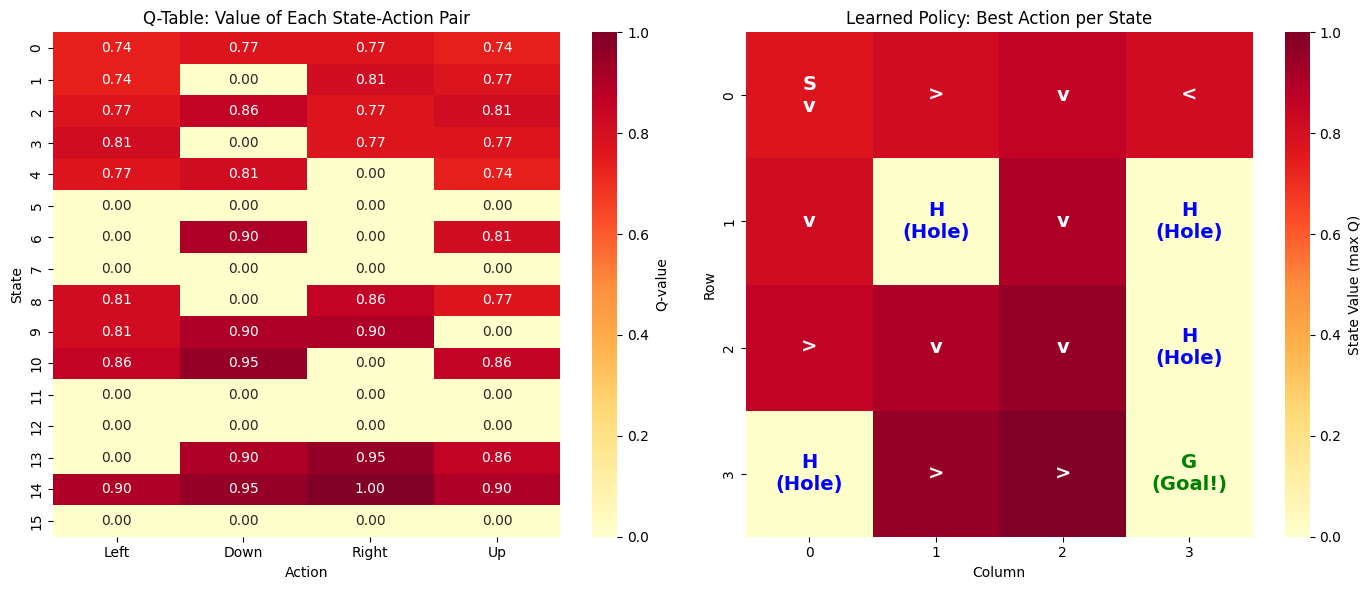


Legend: < = Left, v = Down, > = Right, ^ = Up
H = Hole (terminal, bad), G = Goal (terminal, good), S = Start


In [7]:
def visualize_q_table(q_table, map_size=4):
    """
    Visualize the Q-table as a heatmap with policy arrows.
    
    Args:
        q_table: The learned Q-table (n_states x n_actions)
        map_size: Size of the grid (4 for 4x4 FrozenLake)
    """
    # Action symbols for visualization
    action_symbols = ['<', 'v', '>', '^']  # LEFT, DOWN, RIGHT, UP
    action_names = ['Left', 'Down', 'Right', 'Up']
    
    # FrozenLake map (for reference)
    lake_map = [
        ['S', 'F', 'F', 'F'],
        ['F', 'H', 'F', 'H'],
        ['F', 'F', 'F', 'H'],
        ['H', 'F', 'F', 'G']
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Q-table heatmap
    ax1 = axes[0]
    sns.heatmap(q_table, annot=True, fmt='.2f', cmap='YlOrRd', 
                xticklabels=action_names, ax=ax1, cbar_kws={'label': 'Q-value'})
    ax1.set_xlabel('Action')
    ax1.set_ylabel('State')
    ax1.set_title('Q-Table: Value of Each State-Action Pair')
    
    # Plot 2: Grid with policy arrows and state values
    ax2 = axes[1]
    
    # Create value grid (max Q-value for each state)
    value_grid = np.max(q_table, axis=1).reshape(map_size, map_size)
    
    # Plot heatmap of state values
    sns.heatmap(value_grid, annot=False, cmap='YlOrRd', ax=ax2, 
                cbar_kws={'label': 'State Value (max Q)'})
    
    # Add policy arrows and map labels
    for i in range(map_size):
        for j in range(map_size):
            state = i * map_size + j
            cell_type = lake_map[i][j]
            
            # Get best action for this state
            best_action = np.argmax(q_table[state])
            arrow = action_symbols[best_action]
            
            # Color based on cell type
            if cell_type == 'H':
                text = 'H\n(Hole)'
                color = 'blue'
            elif cell_type == 'G':
                text = 'G\n(Goal!)'
                color = 'green'
            elif cell_type == 'S':
                text = f'S\n{arrow}'
                color = 'white'
            else:
                text = f'{arrow}'
                color = 'white'
            
            ax2.text(j + 0.5, i + 0.5, text, ha='center', va='center', 
                    fontsize=14, fontweight='bold', color=color)
    
    ax2.set_title('Learned Policy: Best Action per State')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    
    plt.tight_layout()
    plt.show()
    
    # Print the optimal path
    print("\nLegend: < = Left, v = Down, > = Right, ^ = Up")
    print("H = Hole (terminal, bad), G = Goal (terminal, good), S = Start")


# Visualize the learned Q-table
visualize_q_table(agent.q_table)

---

## 9. Plot Learning Curve

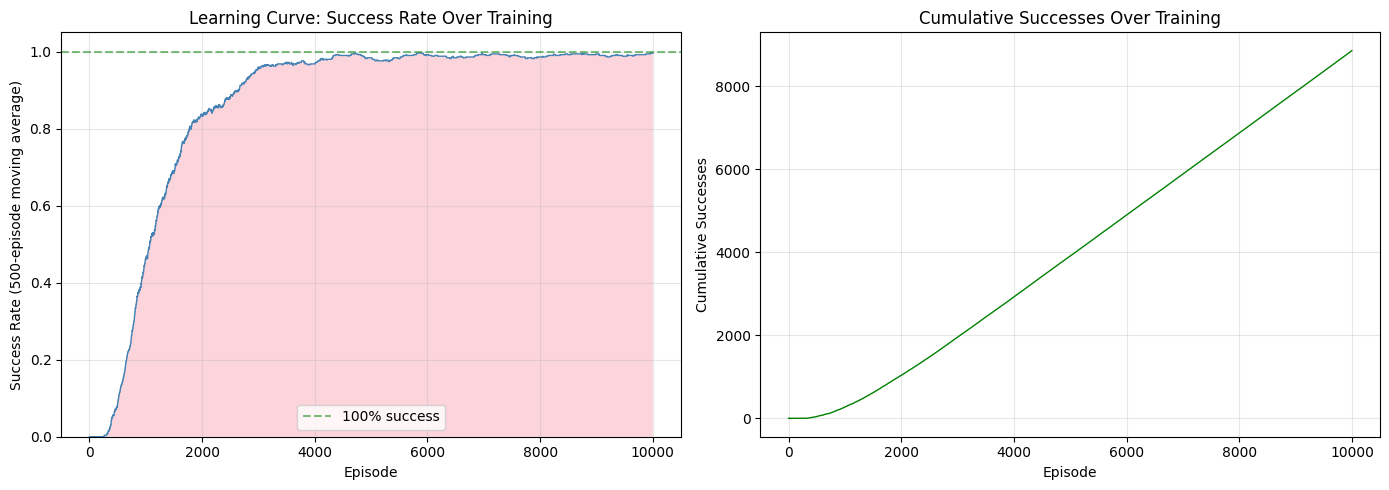


Training Summary:
  Total episodes: 10000
  Total successes: 8860
  Overall success rate: 88.60%
  Final 500-episode success rate: 99.60%


In [8]:
def plot_learning_curve(rewards, window=100):
    """
    Plot the learning curve showing success rate over time.
    
    Args:
        rewards: List of episode rewards
        window: Window size for moving average
    """
    # Calculate moving average of success rate
    successes = [1 if r > 0 else 0 for r in rewards]
    moving_avg = []
    
    for i in range(len(successes)):
        start = max(0, i - window + 1)
        moving_avg.append(np.mean(successes[start:i+1]))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Success rate over time
    ax1 = axes[0]
    ax1.plot(moving_avg, color='steelblue', linewidth=1)
    ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='100% success')
    ax1.fill_between(range(len(moving_avg)), moving_avg, alpha=0.3)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel(f'Success Rate ({window}-episode moving average)')
    ax1.set_title('Learning Curve: Success Rate Over Training')
    ax1.set_ylim(0, 1.05)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative successes
    ax2 = axes[1]
    cumulative = np.cumsum(successes)
    ax2.plot(cumulative, color='green', linewidth=1)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Successes')
    ax2.set_title('Cumulative Successes Over Training')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  Total episodes: {len(rewards)}")
    print(f"  Total successes: {sum(successes)}")
    print(f"  Overall success rate: {sum(successes)/len(rewards):.2%}")
    print(f"  Final {window}-episode success rate: {moving_avg[-1]:.2%}")


# Plot the learning curve
plot_learning_curve(episode_rewards, window=500)

---

## 10. Test Learned Policy Success Rate

In [9]:
def test_policy(env, agent, n_episodes=100, verbose=False):
    """
    Test the learned policy without exploration.
    
    Args:
        env: Gymnasium environment
        agent: Trained Q-learning agent
        n_episodes: Number of test episodes
        verbose: Whether to print each episode result
        
    Returns:
        success_rate: Proportion of successful episodes
    """
    successes = 0
    
    for episode in range(n_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        path = [state]
        
        while not done:
            # Use greedy policy (no exploration)
            action = np.argmax(agent.q_table[state])
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            path.append(state)
        
        if total_reward > 0:
            successes += 1
            if verbose and episode < 5:
                print(f"Episode {episode + 1}: SUCCESS! Path: {path}")
        elif verbose and episode < 5:
            print(f"Episode {episode + 1}: Failed. Path: {path}")
    
    success_rate = successes / n_episodes
    return success_rate


# Test the learned policy
print("Testing learned policy (greedy, no exploration)...")
print("=" * 50)
success_rate = test_policy(env, agent, n_episodes=100, verbose=True)
print("=" * 50)
print(f"\nTest Results: {success_rate:.0%} success rate over 100 episodes")

if success_rate >= 0.9:
    print("\nExcellent! The agent has learned to solve FrozenLake reliably!")
elif success_rate >= 0.7:
    print("\nGood performance! The agent has learned a reasonable policy.")
else:
    print("\nThe agent could use more training or hyperparameter tuning.")

Testing learned policy (greedy, no exploration)...
Episode 1: SUCCESS! Path: [0, 4, 8, 9, 13, 14, 15]
Episode 2: SUCCESS! Path: [0, 4, 8, 9, 13, 14, 15]
Episode 3: SUCCESS! Path: [0, 4, 8, 9, 13, 14, 15]
Episode 4: SUCCESS! Path: [0, 4, 8, 9, 13, 14, 15]
Episode 5: SUCCESS! Path: [0, 4, 8, 9, 13, 14, 15]

Test Results: 100% success rate over 100 episodes

Excellent! The agent has learned to solve FrozenLake reliably!


---

## 11. Experiment: Slippery FrozenLake

Now let's try the **stochastic** version where actions don't always go as planned!

In [10]:
# Create the slippery environment
env_slippery = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)

print("=" * 60)
print("SLIPPERY FROZENLAKE")
print("=" * 60)
print("\nIn slippery mode, actions are stochastic!")
print("When you try to move in a direction, there's a chance you'll")
print("slip and move perpendicular to your intended direction.")
print("\nThis makes the problem MUCH harder because:")
print("  1. You can't always predict where you'll end up")
print("  2. A perfect policy doesn't guarantee success")
print("  3. The agent must learn robust strategies")

SLIPPERY FROZENLAKE

In slippery mode, actions are stochastic!
When you try to move in a direction, there's a chance you'll
slip and move perpendicular to your intended direction.

This makes the problem MUCH harder because:
  1. You can't always predict where you'll end up
  2. A perfect policy doesn't guarantee success
  3. The agent must learn robust strategies


In [11]:
# Train a new agent on slippery FrozenLake
agent_slippery = QLearningAgent(
    n_states=env_slippery.observation_space.n,
    n_actions=env_slippery.action_space.n,
    learning_rate=0.8,
    discount_factor=0.95,
    epsilon_start=1.0,
    epsilon_end=0.1,  # Keep some exploration due to stochasticity
    epsilon_decay=0.999
)

# Train for more episodes since it's harder
rewards_slippery, lengths_slippery = train_q_learning(
    env_slippery, agent_slippery, n_episodes=10000, print_interval=2000
)

Training Q-learning agent for 10000 episodes...
Episode  2000 | Success Rate: 5.15% | Epsilon: 0.1352 | Total Successes: 103
Episode  4000 | Success Rate: 13.10% | Epsilon: 0.1000 | Total Successes: 365
Episode  6000 | Success Rate: 16.45% | Epsilon: 0.1000 | Total Successes: 694
Episode  8000 | Success Rate: 16.00% | Epsilon: 0.1000 | Total Successes: 1014
Episode 10000 | Success Rate: 16.40% | Epsilon: 0.1000 | Total Successes: 1342
Training complete! Final success rate: 13.42%



Slippery FrozenLake Q-Table and Policy:


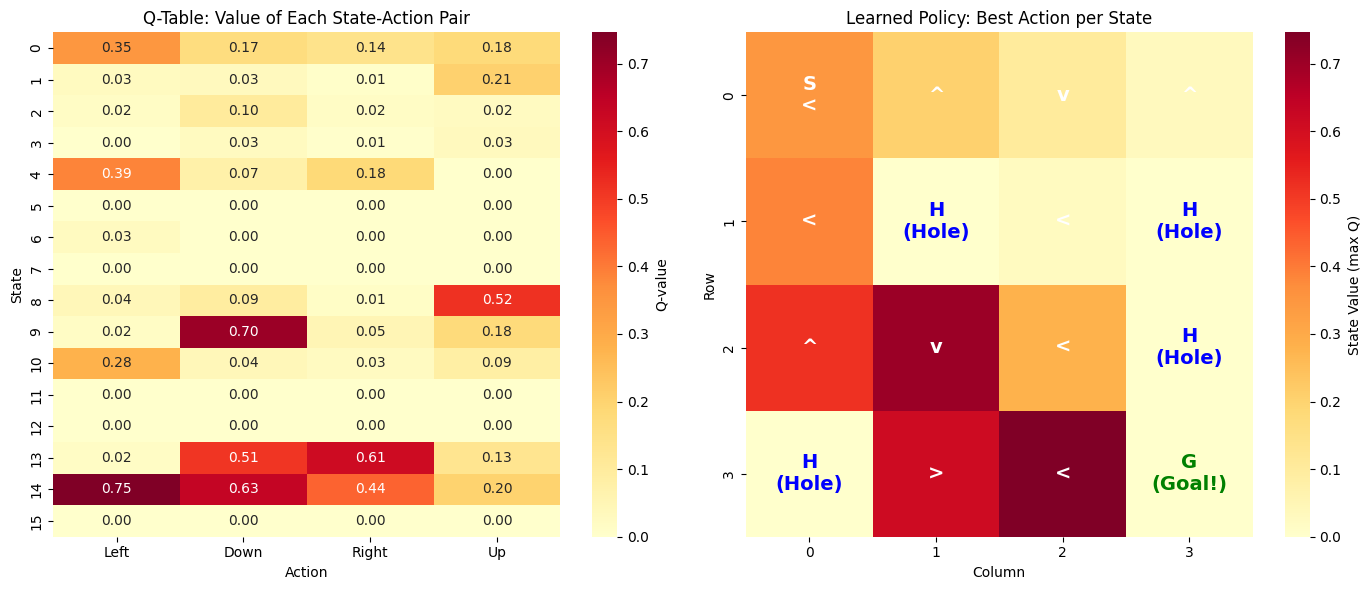


Legend: < = Left, v = Down, > = Right, ^ = Up
H = Hole (terminal, bad), G = Goal (terminal, good), S = Start


In [12]:
# Visualize the slippery Q-table
print("\nSlippery FrozenLake Q-Table and Policy:")
visualize_q_table(agent_slippery.q_table)

In [13]:
# Compare performance
print("\n" + "=" * 60)
print("COMPARISON: Deterministic vs Slippery")
print("=" * 60)

# Test both agents
print("\nDeterministic FrozenLake:")
det_success = test_policy(env, agent, n_episodes=100)
print(f"  Success rate: {det_success:.0%}")

print("\nSlippery FrozenLake:")
slip_success = test_policy(env_slippery, agent_slippery, n_episodes=100)
print(f"  Success rate: {slip_success:.0%}")

print("\nNote: Slippery is inherently harder because even a perfect")
print("policy can fail due to random transitions!")


COMPARISON: Deterministic vs Slippery

Deterministic FrozenLake:
  Success rate: 100%

Slippery FrozenLake:
  Success rate: 0%

Note: Slippery is inherently harder because even a perfect
policy can fail due to random transitions!


---

## 12. Quiz: Test Your Understanding

### Question 1
What does the discount factor (gamma) control in Q-learning?
- A) How fast the agent explores
- B) How much to value future rewards vs immediate rewards
- C) The size of the Q-table
- D) The probability of random actions

<details>
<summary>Click for Answer</summary>
<b>B) How much to value future rewards vs immediate rewards</b>
<br>Gamma (0 to 1) determines the present value of future rewards. A gamma of 0.99 means future rewards are almost as valuable as immediate ones, while gamma of 0 would make the agent only care about immediate rewards.
</details>

---

### Question 2
In the Bellman equation Q(s,a) = R(s,a) + gamma * max Q(s',a'), what does max Q(s',a') represent?
- A) The reward for the current action
- B) The average Q-value across all states
- C) The value of the best action in the next state
- D) The exploration bonus

<details>
<summary>Click for Answer</summary>
<b>C) The value of the best action in the next state</b>
<br>This term represents our estimate of the best possible future value, assuming we act optimally from the next state onward. It's what makes Q-learning "look ahead" to future rewards.
</details>

---

### Question 3
Why do we use epsilon-greedy exploration instead of always taking the best action?
- A) It makes the code simpler
- B) It ensures we discover all possible actions and their outcomes
- C) It speeds up training
- D) It's required by the Bellman equation

<details>
<summary>Click for Answer</summary>
<b>B) It ensures we discover all possible actions and their outcomes</b>
<br>Without exploration, the agent might never try actions that could lead to better outcomes. Epsilon-greedy balances exploiting what we know (best action) with exploring what we don't know (random actions).
</details>

---

### Question 4
Why is slippery FrozenLake harder than deterministic FrozenLake?
- A) It has more states
- B) The reward is smaller
- C) Actions don't always lead to the expected next state
- D) The Q-table is larger

<details>
<summary>Click for Answer</summary>
<b>C) Actions don't always lead to the expected next state</b>
<br>In slippery mode, the transition probabilities P(s'|s,a) are stochastic. Even with a perfect policy, the agent might slip into a hole. The agent must learn strategies that are robust to this uncertainty.
</details>

---

## 13. Cleanup

In [14]:
# Close environments
env.close()
env_slippery.close()

print("Environments closed successfully!")
print("\n" + "=" * 60)
print("CHECKPOINT 2 COMPLETE!")
print("=" * 60)
print("\nKey Takeaways:")
print("1. MDPs formalize RL problems with (S, A, P, R, gamma)")
print("2. The Bellman equation relates current and future values")
print("3. Q-learning iteratively improves value estimates")
print("4. Epsilon-greedy balances exploration and exploitation")
print("5. Stochastic environments require robust policies")
print("\nNext: Deep Q-Learning for continuous state spaces!")

Environments closed successfully!

CHECKPOINT 2 COMPLETE!

Key Takeaways:
1. MDPs formalize RL problems with (S, A, P, R, gamma)
2. The Bellman equation relates current and future values
3. Q-learning iteratively improves value estimates
4. Epsilon-greedy balances exploration and exploitation
5. Stochastic environments require robust policies

Next: Deep Q-Learning for continuous state spaces!
